In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import binascii
import joblib
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier

In [15]:
# load csv of binary data / ASI labels
# smaller data set = `bin-data.csv`     (27 MB)
# larger data set  = `binarydata.csv`   (860 MB)

file = os.path.join(os.getcwd(), "bin-data.csv")
df = pd.read_csv(file, index_col=0)

# transform binary strings to binary data, then make it hex code

mapped = list(map(lambda x: x[x.find('b\'') + 2:].encode(), df['data']))
labels = list(df['label'])

hexdata = [binascii.hexlify(e) for e in mapped]

X_train, X_test, y_train, y_test = train_test_split(hexdata, labels, test_size=0.2, random_state=42069)

In [16]:
# initialize hex data vectorization pipeline

vec_opts = {
    "ngram_range": (1, 4),  # we consider 1-, 2-, 3-, and 4-grams
    "analyzer": "word",
    "token_pattern": "..",  # consecutive characters are words
    "min_df": 0.005,        # terms must be in at least 0.5% of documents
    "max_df": 0.95          # terms can not exist in more than 95% of documents
}

idf_opts = {
    "use_idf": True,
    "sublinear_tf": True    # log transform reduced importance of frequently used terms
}

vectorizer = make_pipeline(
    CountVectorizer(**vec_opts),
    TfidfTransformer(**idf_opts)
)

In [17]:
vectorizer.fit(X_train)

joblib.dump(vectorizer, './models/vectorizer')  # to persist data transformation pipeline

# create vectorized train and test data
XT_train = vectorizer.transform(X_train)
XT_test = vectorizer.transform(X_test)

## PCA Analysis

The PCA plot below demonstrates that the hex data is noticeably clustered after being vectorized

In [22]:
X_pca2 = PCA(n_components=2).fit_transform(XT_train.todense())
pca2_data = pd.DataFrame(X_pca2, columns=['x1', 'x2'])
pca2_data['label'] = y_train
pca2_data.head()

/home/jacob/projects/binary-isa-classifier/env/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


,x1,x2,label
0,0.178685,0.138158,powerpc
1,-0.064736,0.072488,x86_64
2,0.044845,0.057283,m68k
3,-0.096888,0.093034,sh4
4,-0.113113,0.202208,s390


In [19]:
X_pca3 = PCA(n_components=3).fit_transform(XT_train.todense())
pca3_data = pd.DataFrame(X_pca3, columns=['x1', 'x2', 'x3'])
pca3_data['label'] = y_train
pca3_data.head()

/home/jacob/projects/binary-isa-classifier/env/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


,x1,x2,x3,label
0,0.178685,0.138200,-0.236313,powerpc
1,-0.064735,0.072440,-0.024646,x86_64
2,0.044854,0.057371,-0.034468,m68k
3,-0.096886,0.093025,0.132841,sh4
4,-0.113112,0.202196,0.011315,s390


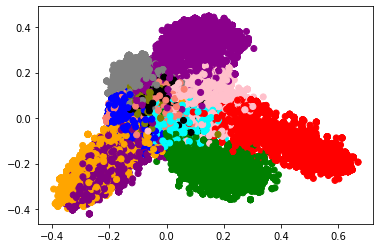

In [23]:
colors = {
    'alphaev56': 'blue', 
    'arm': 'green', 
    'avr': 'red', 
    'm68k': 'black',
    'mips': 'purple',
    'mipsel': 'orange',
    'powerpc': 'pink',
    's390': 'gray',
    'sh4': 'olive', 
    'sparc': 'cyan', 
    'x86_64': 'salmon', 
    'xtensa': 'darkmagenta'
}
plt.scatter(pca2_data['x1'], pca2_data['x2'], c=pca2_data['label'].map(colors))

## Attempt 1:  Naive Bayes Classifier

This model sucks...

In [8]:
NBC = CategoricalNB().fit(XT_train.todense(), y_train)
print(NBC.score(XT_test.todense(), y_test))

/home/jacob/projects/binary-isa-classifier/env/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/jacob/projects/binary-isa-classifier/env/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.08766686590954373


## Attempt 2: Linear SVC

Great results!

In [24]:
lSVC = LinearSVC(penalty='l2', tol=1e-04).fit(XT_train, y_train)
print(lSVC.score(XT_test, y_test))

0.9996413628212791


## Attempt 3: Linear SGD

In [31]:

loss_types = [None, "log", "modified_huber", "squared_hinge", "perceptron"]
penalty_types = ['l2', 'l1', 'elasticnet']

N = len(loss_types)
M = len(penalty_types)

models = [[None for _ in range(M)] for _ in range(N)]
for idx, loss in enumerate(loss_types):
    for jdx, pen in enumerate(penalty_types):
        params = {
            "tol": 1e-06
        }
        if loss:
            params["loss"] = loss
        params["penalty"] = pen
        try:
            models[idx][jdx] = SGDClassifier(**params).fit(XT_train, y_train)
        except:
            models[idx][jdx] = None

/home/jacob/projects/binary-isa-classifier/env/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/jacob/projects/binary-isa-classifier/env/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/jacob/projects/binary-isa-classifier/env/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
for i in range(N):
    for j in range(M):
        print(f"loss={loss_types[i]}, penalty={penalty_types[j]}:\t{models[i][j].score(XT_test, y_test) if models[i][j] else np.nan}")

Winning linear SGD models (loss, penalty):
- perceptron / l2  (0.9994)
- modified_huber / l2  (0.999)

## Attempt 4: SVC
Except now we dont use the linear kernel

In [10]:
# default kernel is RBF
kernels = ['rbf', 'poly', 'sigmoid']

for kernel_type in kernels:
    model = SVC(kernel=kernel_type).fit(XT_train, y_train)
    print(f"kernel={kernel_type}:\t\t{model.score(XT_test, y_test) if model else np.nan}")

kernel=rbf:		0.999721059972106
kernel=poly:		0.9996812113966925
kernel=sigmoid:		0.9990436341900777


TypeError: Sparse precomputed kernels are not supported.

Best SVC kernels: 
- rbf
- linear

In [18]:
lSVC = LinearSVC(penalty='l2', tol=1e-04).fit(XT_train, y_train)
rbfSVC = SVC(kernel='rbf').fit(XT_train, y_train)
perceptron_sgd = SGDClassifier(loss='perceptron', tol=1e-06).fit(XT_train, y_train)
mhuber_sgd = SGDClassifier(loss='modified_huber', tol=1e-06).fit(XT_train, y_train)

joblib.dump(lSVC, './models/linearSVC')
joblib.dump(rbfSVC, './models/rbfSVC')
joblib.dump(perceptron_sgd, './models/perceptron_sgd')
joblib.dump(mhuber_sgd, './models/mhuber_sgd')

['./models/mhuber_sgd']